In [ ]:
!pip install -q ultralytics roboflow opencv-python matplotlib

In [ ]:
!pip install scikit-learn joblib

In [ ]:
from ultralytics import YOLO
from roboflow import Roboflow
import cv2
import matplotlib.pyplot as plt
import yaml
from pathlib import Path
from glob import glob
import cv2

In [ ]:
ROBOFLOW_API_KEY = 'ZeqDUbrUSOriIWblOi1E'

In [ ]:
rf = Roboflow(api_key = ROBOFLOW_API_KEY)

In [ ]:
ROBOFLOW_WORKSPACE = 'keshandirisa'
ROBOFLOW_PROJECT = 'car-accident-dashcam-bjuu7'
ROBOFLOW_VERSION = 1


In [ ]:
project = rf.workspace(ROBOFLOW_WORKSPACE).project(ROBOFLOW_PROJECT)
dataset = project.version(ROBOFLOW_VERSION).download('yolov8')

for v in project.versions():
    print(f" - Version: {v.id}, Images: {v.images}, Created at: {v.created}")

loading Roboflow workspace...
loading Roboflow project...
 - Version: keshandirisa/car-accident-dashcam-bjuu7/1, Images: 144, Created at: 1764633283.166


In [ ]:
dataset_dir = Path(dataset.location)
data_yaml = dataset_dir / 'data.yaml'

print('Dataset directory: ', dataset_dir)
print('data.yaml path: ', data_yaml)

assert data_yaml.exists(), 'data.yaml file does not exist'

Dataset directory:  /content/car-accident-dashcam-1
data.yaml path:  /content/car-accident-dashcam-1/data.yaml


In [ ]:
with open(data_yaml, 'r') as f:
  data_cfg = yaml.safe_load(f)

print('Classes: ', data_cfg.get('names'))
print('Train path:', data_cfg.get('train'))
print('Validation path:', data_cfg.get('val'))

Classes:  ['vehicle', 'vehicle-accident']
Train path: ../train/images
Validation path: ../valid/images


In [ ]:
# Grabbing Training Images as a visual check
train_imgs = glob(str(dataset_dir / 'train' / 'images'/ '*'))
print('Number of training images: ', len(train_imgs))

Number of training images:  101


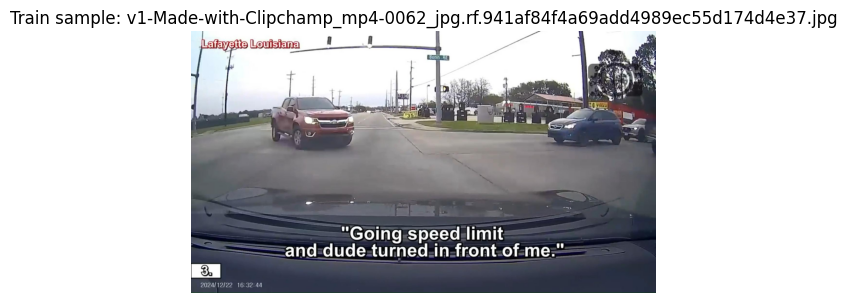

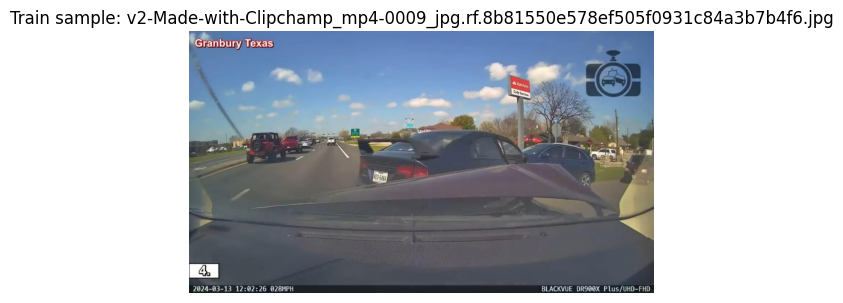

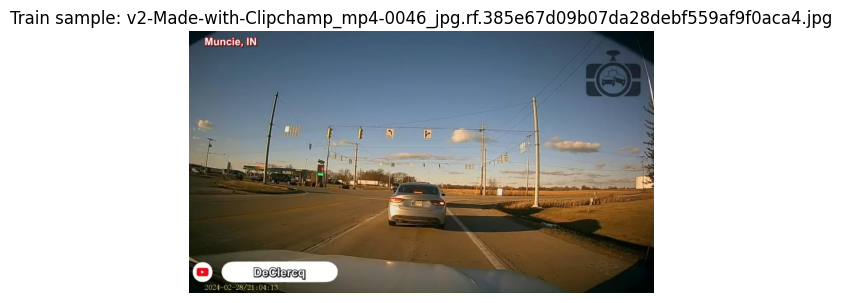

In [ ]:
for img_path in train_imgs[:3]:
  img = cv2.imread(img_path)
  img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
  plt.figure(figsize = (6, 4))
  plt.imshow(img)
  plt.axis('off')
  plt.title(f'Train sample: {Path(img_path).name}')
  plt.show()

In [ ]:
MODEL_WEIGHTS = 'yolo11n.pt'
EPOCHS = 7
BATCH_SIZE = 16
IMG_SIZE = 640
DEVICE = 'cpu'
RUN_NAME = 'driver_behavior_yolo12n'

model = YOLO(MODEL_WEIGHTS)
model.info()

YOLO11n summary: 181 layers, 2,624,080 parameters, 0 gradients, 6.6 GFLOPs


(181, 2624080, 0, 6.614336)

In [ ]:
results = model.train(
    data = str(data_yaml),
    epochs = EPOCHS,
    batch = BATCH_SIZE,
    imgsz = IMG_SIZE,
    device = DEVICE,
    name = RUN_NAME,
    pretrained = True,
    workers = 4,
    patience = 10 # early stopping
)

Ultralytics 8.3.234 🚀 Python-3.12.12 torch-2.9.0+cu126 CPU (Intel Xeon CPU @ 2.20GHz)
engine/trainer: agnostic_nms=False, amp=True, augment=False, auto_augment=randaugment, batch=16, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, compile=False, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=/content/car-accident-dashcam-1/data.yaml, degrees=0.0, deterministic=True, device=cpu, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, epochs=7, erasing=0.4, exist_ok=False, fliplr=0.5, flipud=0.0, format=torchscript, fraction=1.0, freeze=None, half=False, hsv_h=0.015, hsv_s=0.7, hsv_v=0.4, imgsz=640, int8=False, iou=0.7, keras=False, kobj=1.0, line_width=None, lr0=0.01, lrf=0.01, mask_ratio=4, max_det=300, mixup=0.0, mode=train, model=yolo11n.pt, momentum=0.937, mosaic=1.0, multi_scale=False, name=driver_behavior_yolo12n2, nbs=64, nms=False, opset=None, optimize=False, optimizer=auto, overlap_mask=True, patience=10, per

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from pathlib import Path

def evaluate_yolo_model(
    model,
    data_yaml,
    imgsz=640,
    device=0,
    conf=0.25,
    iou=0.5,
    results_dir=None,   # <- pass runs/detect/... directory to plot loss curves
):
    """
    Run validation for an Ultralytics YOLO model and show:
      - mAP metrics
      - Overall P / R / F1 / approx accuracy
      - Per-class metrics
      - Bar charts for AP, P, R, F1
      - Confusion matrix (if available)
      - Train & validation loss curves (if results.csv is available)
    """

    # ---- 1. Run validation ----
    metrics = model.val(
        data=str(data_yaml),
        imgsz=imgsz,
        device=device,
        conf=conf,
        iou=iou,
    )

    # ---- 2. Summary mAP metrics ----
    print("\n========== GLOBAL DETECTION METRICS ==========")
    print(f"mAP50-95 : {metrics.box.map:.4f}")
    print(f"mAP50    : {metrics.box.map50:.4f}")
    print(f"mAP75    : {metrics.box.map75:.4f}")

    # ---- 3. Per-class P/R/AP ----
    ap_per_class   = metrics.box.maps                  # AP per class
    prec_per_class = metrics.box.p                     # precision per class
    rec_per_class  = metrics.box.r                     # recall per class
    f1_per_class   = metrics.box.f1                    # F1 score per class

    # Approx per-class accuracy using P, R
    acc_per_class = []
    for P, R in zip(prec_per_class, rec_per_class):
        TP = R
        FP = TP * (1 / P - 1) if P > 0 else 0.0
        FN = 1 - R
        denom = TP + FP + FN
        acc = TP / denom if denom > 0 else 0.0
        acc_per_class.append(acc)
    acc_per_class = np.array(acc_per_class)

    overall_precision = float(np.mean(prec_per_class))
    overall_recall    = float(np.mean(rec_per_class))
    overall_f1        = float(np.mean(f1_per_class))
    overall_acc       = float(np.mean(acc_per_class))

    print("\n========== GLOBAL CLASSIFICATION SUMMARY ==========")
    print(f"Overall Precision : {overall_precision:.4f}")
    print(f"Overall Recall    : {overall_recall:.4f}")
    print(f"Overall F1        : {overall_f1:.4f}")
    print(f"Approx Accuracy   : {overall_acc:.4f}")

    # ---- 4. Per-class breakdown ----
    print("\n========== PER-CLASS METRICS ==========")
    for cls_id, cls_name in metrics.names.items():
        print(
            f"[{cls_id}] {cls_name:20s} | "
            f"AP={ap_per_class[cls_id]:.3f} | "
            f"P={prec_per_class[cls_id]:.3f} | "
            f"R={rec_per_class[cls_id]:.3f} | "
            f"F1={f1_per_class[cls_id]:.3f} | "
            f"Acc\u2248{acc_per_class[cls_id]:.3f}"
        )

    # ---- 5. Bar charts for AP, P, R, F1 ----
    classes = [metrics.names[i] for i in range(len(metrics.names))]
    x = np.arange(len(classes))

    def _barplot(values, title, ylabel):
        plt.figure(figsize=(max(8, len(classes) * 0.6), 4))
        plt.bar(x, values)
        plt.xticks(x, classes, rotation=45, ha="right")
        plt.title(title)
        plt.ylabel(ylabel)
        plt.tight_layout()
        plt.show()

    _barplot(ap_per_class,   "Average Precision (AP) per Class", "AP")
    _barplot(prec_per_class, "Precision per Class",              "Precision")
    _barplot(rec_per_class,  "Recall per Class",                 "Recall")
    _barplot(f1_per_class,   "F1 Score per Class",               "F1")

    # ---- 6. Confusion matrix (if available) ----
    cm = None
    if hasattr(metrics, "confusion_matrix") and metrics.confusion_matrix is not None:
        try:
            cm = metrics.confusion_matrix.matrix
        except AttributeError:
            cm = getattr(metrics.confusion_matrix, "matrix", None)

    if cm is not None:
        # For detection tasks, confusion matrix is (nc+1, nc+1); last row/col are background
        if cm.shape[0] == len(classes) + 1:
            cm = cm[:-1, :-1]

        cm_norm = cm / (cm.sum(axis=1, keepdims=True) + 1e-9)

        plt.figure(figsize=(max(8, len(classes) * 0.6), max(6, len(classes) * 0.6)))
        im = plt.imshow(cm_norm, interpolation="nearest", cmap="Blues")
        plt.title("Normalized Confusion Matrix")
        plt.colorbar(im, fraction=0.046, pad=0.04)
        tick_marks = np.arange(len(classes))
        plt.xticks(tick_marks, classes, rotation=45, ha="right")
        plt.yticks(tick_marks, classes)
        plt.ylabel("True Class")
        plt.xlabel("Predicted Class")
        plt.tight_layout()
        plt.show()
    else:
        print("\n[Info] Confusion matrix not available on metrics; "
              "update Ultralytics if you need it.")

    # ---- 7. Train & validation loss curves (from results.csv) ----
    if results_dir is None:
        # Try to infer from model.trainer if still in the same session
        save_dir = getattr(getattr(model, "trainer", None), "save_dir", None)
        if save_dir is not None:
            results_dir = Path(save_dir)
        else:
            print("\n[Info] results_dir not provided and could not infer from model.trainer; "
                  "skipping loss curves.")
            results_csv = None
    else:
        results_dir = Path(results_dir)
        results_csv = results_dir / "results.csv"

    if results_dir is not None:
        results_csv = results_dir / "results.csv"
        if results_csv.exists():
            print(f"\n[Info] Loading training history from: {results_csv}")
            df = pd.read_csv(results_csv)

            if "epoch" not in df.columns:
                print("[Warning] 'epoch' column not found in results.csv; skipping loss curves.")
            else:
                # Identify loss columns
                train_loss_cols = [c for c in df.columns if c.startswith("train/") and c.endswith("_loss")]
                val_loss_cols   = [c for c in df.columns if c.startswith("val/")   and c.endswith("_loss")]

                if not train_loss_cols or not val_loss_cols:
                    print("[Warning] No train/val loss columns found in results.csv; "
                          "column names may differ in your version.")
                else:
                    df["train_total_loss"] = df[train_loss_cols].sum(axis=1)
                    df["val_total_loss"]   = df[val_loss_cols].sum(axis=1)

                    plt.figure(figsize=(8, 5))
                    plt.plot(df["epoch"], df["train_total_loss"], label="Train total loss")
                    plt.plot(df["epoch"], df["val_total_loss"],   label="Val total loss")
                    plt.xlabel("Epoch")
                    plt.ylabel("Loss")
                    plt.title("Train vs Validation Loss")
                    plt.legend()
                    plt.grid(True, alpha=0.3)
                    plt.tight_layout()
                    plt.show()
        else:
            print(f"\n[Info] results.csv not found in {results_dir}; skipping loss curves.")

    return {
        "metrics": metrics,
        "ap_per_class": ap_per_class,
        "precision_per_class": prec_per_class,
        "recall_per_class": rec_per_class,
        "f1_per_class": f1_per_class,
        "accuracy_per_class": acc_per_class,
        "overall": {
            "precision": overall_precision,
            "recall": overall_recall,
            "f1": overall_f1,
            "accuracy": overall_acc,
            "map50_95": float(metrics.box.map),
            "map50": float(metrics.box.map50),
            "map75": float(metrics.box.map75),
        },
    }

Ultralytics 8.3.234 🚀 Python-3.12.12 torch-2.9.0+cu126 CPU (Intel Xeon CPU @ 2.20GHz)
val: Fast image access ✅ (ping: 0.0±0.0 ms, read: 2508.5±871.4 MB/s, size: 136.8 KB)
val: Scanning /content/car-accident-dashcam-1/valid/labels.cache... 29 images, 1 backgrounds, 0 corrupt: 100% ━━━━━━━━━━━━ 29/29 32.6Kit/s 0.0s
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 2/2 2.0s/it 4.1s
                   all         29         93          0          0          0          0
               vehicle         21         77          0          0          0          0
      vehicle-accident         13         16          0          0          0          0
Speed: 1.1ms preprocess, 117.5ms inference, 0.0ms loss, 0.1ms postprocess per image
Results saved to /content/runs/detect/val3

========== GLOBAL DETECTION METRICS ==========
mAP50-95 : 0.0000
mAP50    : 0.0000
mAP75    : 0.0000

========== GLOBAL CLASSIFICATION SUMMARY ==========
Overall Pre

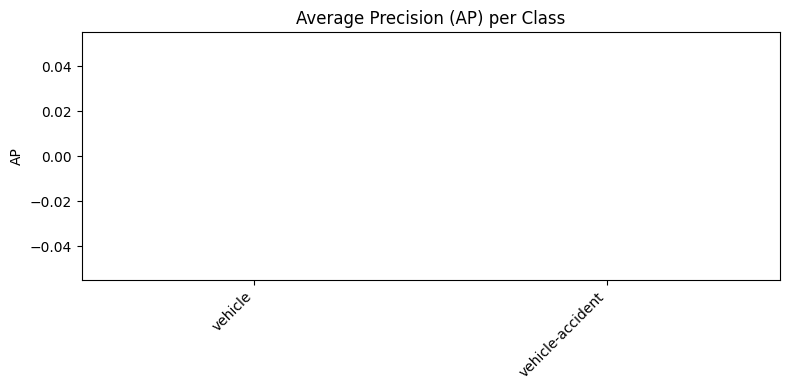

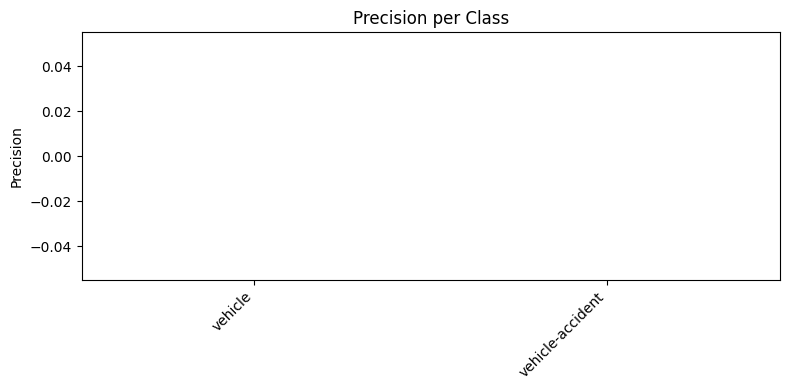

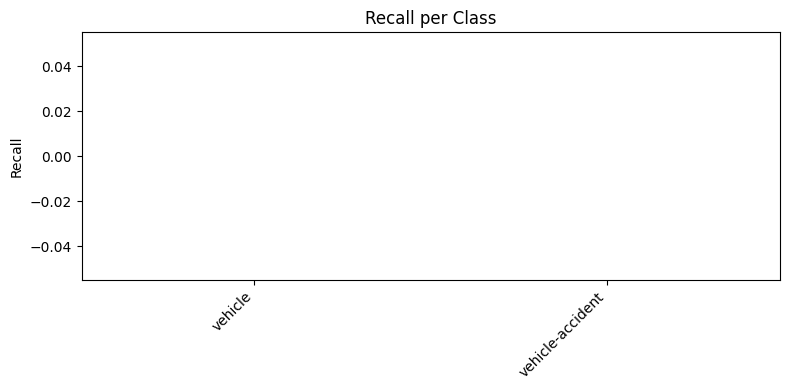

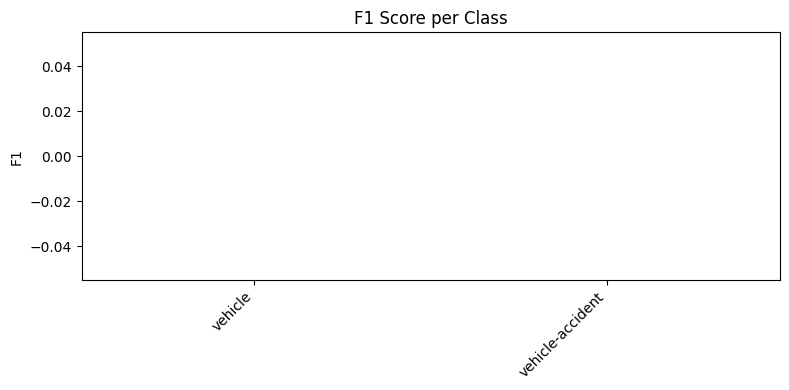

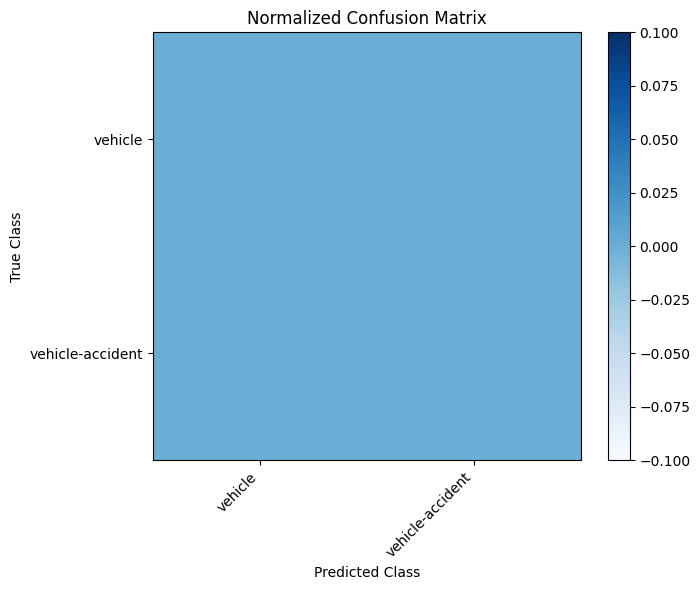


[Info] Loading training history from: /content/runs/detect/driver_behavior_yolo12n2/results.csv


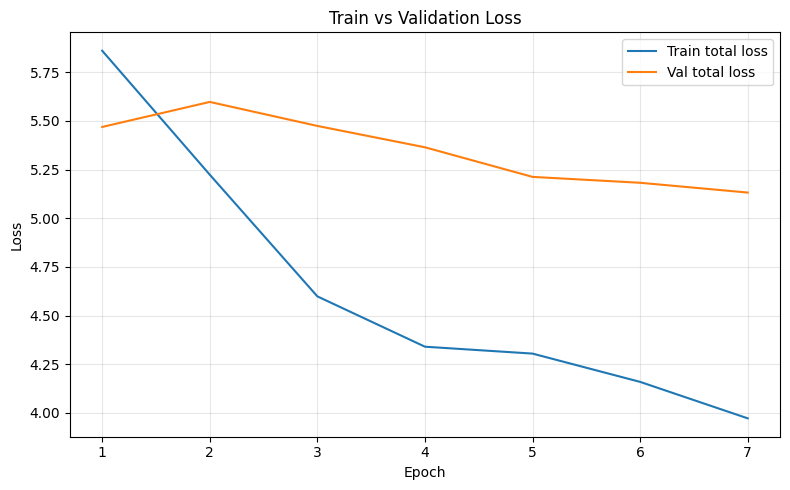

In [ ]:
results_dict = evaluate_yolo_model(
    y11_model,
    data_yaml=data_yaml,
    imgsz=IMG_SIZE,
    device=DEVICE,
    conf=0.25,
    iou=0.5,
    # results_dir optional; if omitted, it tries model.trainer.save_dir
)

In [ ]:
val_imgs = glob(str(dataset_dir / 'valid' / 'images'/ '*'))
print('Number of validation images: ', len(val_imgs))

Number of validation images:  29


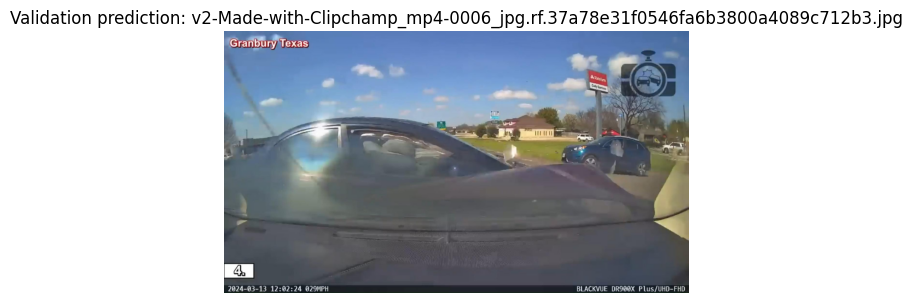

In [ ]:
for img_path in val_imgs[:3]:
  results = model.predict(
      source = img_path,
      imgsz = IMG_SIZE,
      conf = 0.25,
      device = DEVICE,
      verbose = False
  )

annoted = results[0].plot() # draws bounding boxes and labels
annoted = cv2.cvtColor(annoted, cv2.COLOR_BGR2RGB)

plt.figure(figsize = (6, 4))
plt.imshow(annoted)
plt.axis('off')
plt.title(f'Validation prediction: {Path(img_path).name}')
plt.show()

In [ ]:
best_weights = Path('runs')/'detect'/'driver_behavior_yolo12n2'/'weights'/'best.pt'
print('Best weights path: ', best_weights.resolve())
assert best_weights.exists(), 'best.pt does not exist'

y11_model = YOLO(str(best_weights))

Best weights path:  /content/runs/detect/driver_behavior_yolo12n2/weights/best.pt


In [ ]:
test_imgs = glob(str(dataset_dir / 'test' / 'images'/ '*'))
print('Number of test images: ', len(test_imgs))

Number of test images:  14


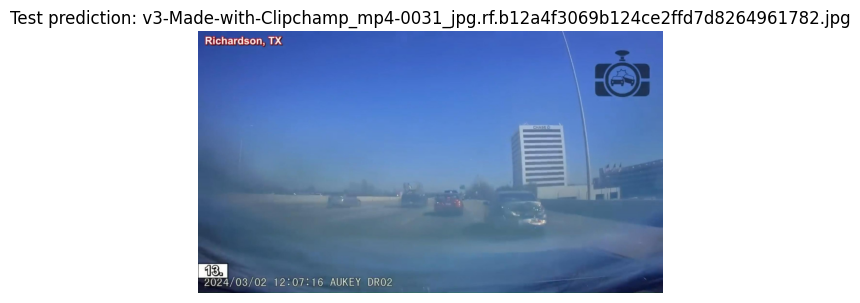

In [ ]:
for img_path in test_imgs[:3]:
  results = y11_model.predict(
       source = img_path,
       imgsz = IMG_SIZE,
       conf = 0.25,
       device = DEVICE,
       verbose = False
  )

annotated = results[0].plot()
annotated = cv2.cvtColor(annotated, cv2.COLOR_BGR2RGB)

plt.figure(figsize = (6, 4))
plt.imshow(annotated)
plt.axis('off')
plt.title(f'Test prediction: {Path(img_path).name}')
plt.show()
